## Layer-wise probe visualization

In [1]:
# Cell 1: Load data and set up
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MultipleLocator

insight_file1 = "probe_detailed_insight.csv"
insight_file11 = "probe_detailed_insight_11.csv"
insight_file111 = "probe_detailed_insight_111.csv"
df1 = pd.read_csv(insight_file1)
df11 = pd.read_csv(insight_file11)
df111 = pd.read_csv(insight_file111)

layers = df1["layer"]

### 1. Layer-criticality curve

#### Why: Peaks identify “critical” layers where information is most easily linearly extracted.

#### Interpretation

Figure shows the overall accuracy by layer in different L1 coefficients used for training linear classifier. Overall, all lines follow similar rising trend in spite of different at different layer. When regularization coefficient is lower (e.g., 0.003, 0.001), we see rice in accuracy from random in some layers, indicating where may tense is encoded prominently. When C=0.003, the initial rise is in layer 8 (until layer 11), and second highest accuracy is around layer 18 (rises slowly until final layer). When C=0.001, the first rise is in layer 18 (slowly rising until 22), next big increase is around layer 27 (slowly increasing until final layer).


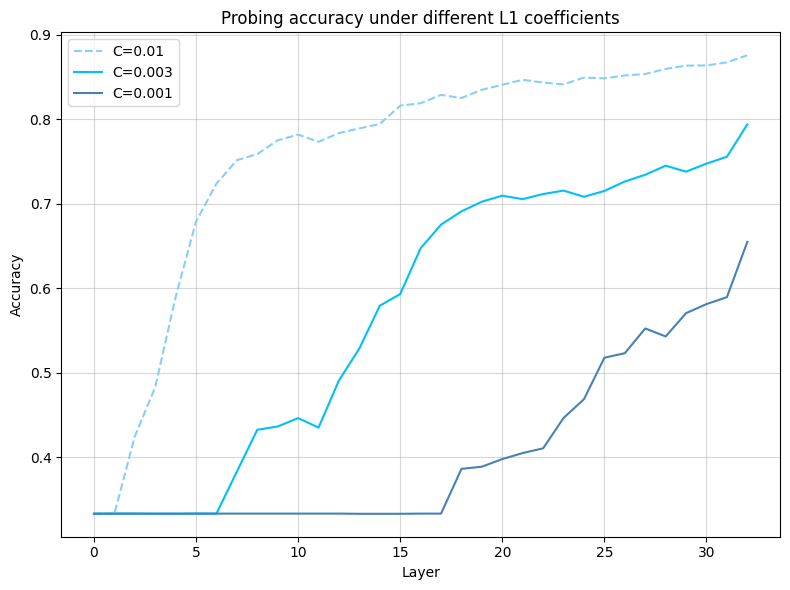

In [23]:
# Cell 2: (1) Layer-criticality curve (overall_accuracy vs layer)
plt.figure(figsize=(8,6))

plt.plot(layers, df1["overall_acc"], label="C=0.01", color="lightskyblue", linestyle="--")
plt.plot(layers, df11["overall_acc"], label="C=0.003", color="deepskyblue")
plt.plot(layers, df111["overall_acc"], label="C=0.001", color="steelblue")

plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.title("Probing accuracy under different L1 coefficients")
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

### Language heatmap

#### Why: Reveals whether different layers encode certain languages better.

#### How to read it

- Row patterns: scan across a single layer-row to see which languages that layer represents best. A row with overall light cells means that layer encodes tense distinctions robustly for most languages.

- Column patterns: scan down a language-column to see at what depth the model encodes that language’s tense most linearly. A peak (lightest cell) pinpoints the optimal layer for that language.

- Diagonal shifts or offsets: if one language peaks systematically earlier or later than others, it indicates typological differences in where tense emerges.

#### Interpretation

When C=0.01
- Row pattern: L4-7 seem to encode tense better
- Column pattern: Later layers has the highest accuracy in all languages
- Offsets: (Hindi), (Thai, English), (Italian, Portuguese, Spanish), (German, French)

### Tense line plots

#### Why: Shows which layers most clearly separate each tense.

## Further interpretation for C=0.01

In [2]:
lang_cols = [c for c in df1.columns if c.startswith("acc_")]
lang_cols

['acc_en',
 'acc_de',
 'acc_fr',
 'acc_it',
 'acc_pt',
 'acc_es',
 'acc_hi',
 'acc_th']

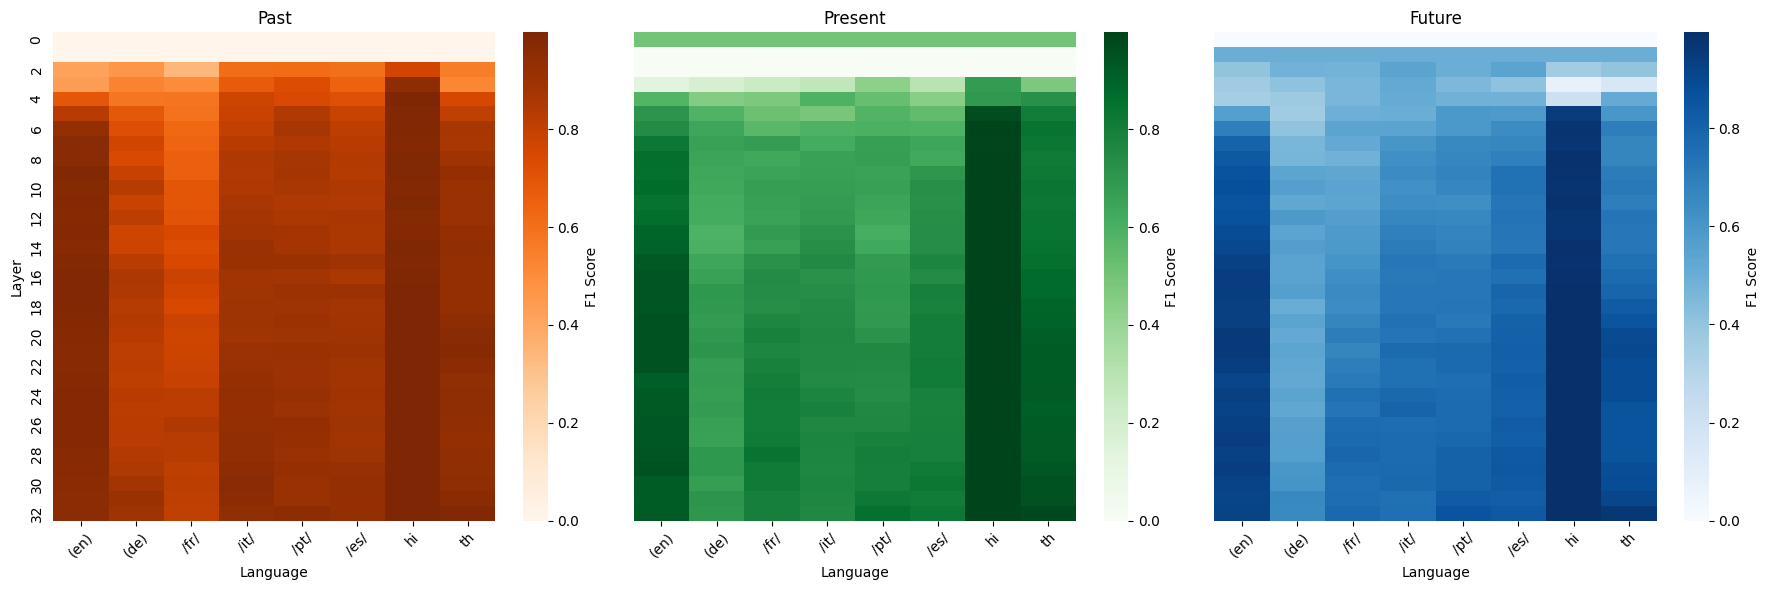

In [4]:
# 1. Melt into long form
tense_cols = [col for col in df1.columns if col.startswith("f1_") and len(col.split("_")) == 3]
keep_cols = ["layer"] + tense_cols
df_long = df1[keep_cols].melt(
    id_vars=["layer"],
    value_vars=tense_cols,
    var_name="lang_tense",
    value_name="f1_score"
)
df_long[["ignore","language","tense"]] = df_long["lang_tense"].str.split("_", expand=True)
df_long = df_long.drop(columns=["ignore","lang_tense"])

# 2. Pivot so index=layer, columns=(language, tense)
df_pivot = df_long.pivot_table(index="layer", columns=["language","tense"], values="f1_score")

# 3. Extract three DataFrames by tense
language_order = ["en","de","fr","it","pt","es","hi","th"]
language_order_label = ["(en)","(de)","/fr/","/it/","/pt/","/es/","hi","th"]
df_past = df_pivot.xs("past", level="tense", axis=1)[language_order]
df_present = df_pivot.xs("present", level="tense", axis=1)[language_order]
df_future = df_pivot.xs("future", level="tense", axis=1)[language_order]

# 4. Create subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.heatmap(df_past, ax=axes[0], cmap="Oranges", cbar_kws={"label":"F1 Score"})
axes[0].set_title("Past")
axes[0].set_xlabel("Language")
axes[0].set_ylabel("Layer")

sns.heatmap(df_present, ax=axes[1], cmap="Greens", cbar_kws={"label":"F1 Score"})
axes[1].set_title("Present")
axes[1].set_xlabel("Language")
axes[1].set_ylabel("")

sns.heatmap(df_future, ax=axes[2], cmap="Blues", cbar_kws={"label":"F1 Score"})
axes[2].set_title("Future")
axes[2].set_xlabel("Language")
axes[2].set_ylabel("")

for ax in axes:
    ax.set_xticklabels(language_order_label, rotation=45)
    ax.tick_params(left=False)

plt.tight_layout()
plt.show()